# Stochastic Optimisation Project 2025
by Timur Kharisov, Redouane Yagouti and William Ford.


### Problem description

In this project we implement X different optimisation algorithms for MNIST, using logistic regression with an L2 regularisation term. The data $x \in \mathbb{R}^{784} $ are 60,000 $28 \times 28$ greyscale images of digits from $0$-$9$, of which 12,000 were used for validation, and a further 10,000 further for testing. These are labelled as binary unit vectors $y\mathbb{R}^{10}$ with $y_i = 1$ if the image represents the digit $i$, else $y_j =0$.


The model parameters are a weights $W \in \R^{784 \times 10}$ (we use no biases), and logistic cost for a pair $(x, y)$
$$
f_{W} : \mathbb{R}^{784} \to \mathbb{R}
$$
$$
(x, y) \mapsto \log\left( \sum_{j=1}^{9} \exp(Wx)\right) - \langle y, Wx\rangle_{\mathbb{R}^{10}}
$$
Assuming the law of $(x, y) \sim \mathcal{D}$ is unknown the objective is
$$
F_\alpha(W) = \mathbb{E}_{(x, y) \sim \mathcal{D}}[f_{W}(x, y)] + \frac{\alpha}{2} \lVert W \rVert^2
$$
where $\alpha$ is a regularisation hyperparameter which we would like to choose optimally. We would like to solve
$$
\min_{W} F_\alpha(W).
$$
By the law of large numbers, we approximate the expectation with the empirical mean over the training data and solve the problem
$$
\underset{W}{\operatorname{Argmin}} \; \hat{F}_\alpha(W) := \frac{1}{48000} \sum_{i=1}^{48000} f_{W}(x_i^{\text{train}}, y_i^{\text{train}}) + \frac{\alpha}{2} \lVert W \rVert^2
$$
This amounts to a convex optimisation problem in $\mathbb{R}^{7840}$, which is further strongly $\alpha$-convex from the regularisation term.

Searching for the optimal $\alpha$, we consider an accuracy of average success of parameters $W$;
$$
L(W) = \frac{1}{12000} \sum_{i=1}^{12000} l(W, x_i^{\text{valid}}, y_i^{\text{valid}})
$$
where $l(x, y) = 1$ if $Wx$ and $y$ have the same largest coordinate and $0$ if not. We then want to identify
$$
\underset{\alpha}{\operatorname{Argmax}}\left\{ L(W_\alpha) : W_\alpha = \underset{W}{\operatorname{Argmin}} \; \hat{F}_\alpha(W)\right\}.
$$

### Implementation


We

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# Fixing the seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

tensor(5)


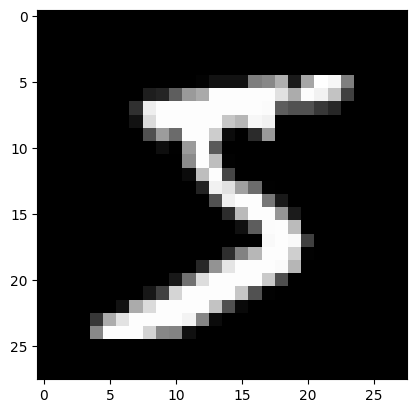

In [ ]:
train_data, test_data = datasets.MNIST('data', train=True, download=True), datasets.MNIST('data', train=False, download=True)
x_train = train_data.data.view(-1, 28*28).float() / 255.0
y_train = train_data.targets
print(y_train[0])
plt.imshow(train_data[0][0], cmap='gray')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Define the model as a subclass of nn.Module
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.w = nn.Parameter(torch.randn(input_dim, num_classes))

    def forward(self, x):
        return x @ self.w
    
def F_alpha_loss(model, x, target, alpha):
    logits = model(x) # (batch_size, num_classes)
    # we substract max_logits from exponential 
    # and then add them back for numerical stability
    max_logits = logits.max(dim=1, keepdim=True).values
    log_sum_exp = max_logits + (logits - max_logits).exp().sum(dim=1, keepdim=True).log() # (batch_size, 1)

    labels = target.unsqueeze(1) # (batch_size, 1)
    y_train = torch.zeros_like(logits).scatter(1, labels, 1) # (batch_size, num_classes)
    subtract_term = (y_train * logits).sum(dim=1, keepdim=True) # (batch_size, 1)

    loss_data = torch.mean(log_sum_exp - subtract_term) # scalar

    alpha_term = 0.5 * alpha * torch.sum(model.w ** 2)

    return loss_data + alpha_term

In [ ]:
def train(model, train_loader, alpha, optimizer, optimizer_params,
          num_epochs=10):
    model.to(device)
    model.train()
    opt = optimizer(model.parameters(), **optimizer_params)
    epoch_losses = []

    for epoch in range(num_epochs):
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            opt.zero_grad()
            loss = F_alpha_loss(model, x_batch, y_batch, alpha)
            loss.backward()
            opt.step()
        # print(f'Epoch {epoch}, Loss: {loss.item()}')
        epoch_losses.append(loss.item())

    plt.plot(epoch_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss for alpha = {}'.format(alpha))
    plt.show()

    return model

In [ ]:
def test(model, val_loader):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            predictions = logits.argmax(dim=1)
            total += y_batch.size(0)
            correct += (predictions == y_batch).sum().item()

    return correct / total

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

def solve_bilevel(alpha_range,
                   train_data,
                   val_loader,
                   optimizer,
                   optimizer_params,
                   num_epochs=10,
                   batch_size=64):
    best_alpha = None
    best_acc = 0
    best_model = None

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    input_dim = train_data.tensors[0].shape[1]
    num_classes = len(np.unique(train_data.tensors[1].numpy()))

    for alpha in alpha_range:
        print(f'Alpha: {alpha}')
        model = LogisticRegression(input_dim, num_classes)
        model = train(model, train_loader, alpha, optimizer, optimizer_params, num_epochs)
        acc = test(model, val_loader)
        print(f'Accuracy: {acc}')

        if acc > best_acc:
            best_acc = acc
            best_alpha = alpha
            best_model = model
    
    print(f'Best alpha: {best_alpha}, Best accuracy: {best_acc}')
    return best_alpha, best_acc, best_model

In [ ]:
from torch.optim import Optimizer

class DummySGD(Optimizer):
    def __init__(self, params, lr=0.1):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        defaults = dict(lr=lr)
        super(DummySGD, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                p.data.add_(-group['lr'], d_p)
        return loss

In [ ]:
# CONSTANTS
ALPHA_RANGE = [0.0001, 0.005, 0.01, 0.05, 0.1]
NUM_EPOCHS = 10
OPTIMIZER_PARAMS = {'lr': 0.1}
BATCH_SIZE = 64
TRAIN_VAL_SPLIT_RATIO = 0.8
OPTIMIZER = DummySGD

784
Alpha: 0.0001


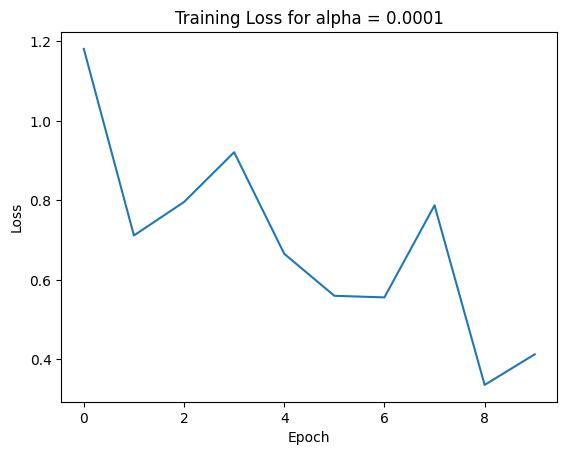

Accuracy: 0.8954166666666666
Alpha: 0.005


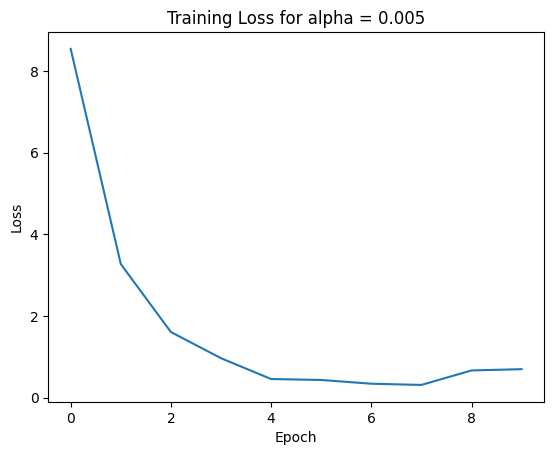

Accuracy: 0.9109166666666667
Alpha: 0.01


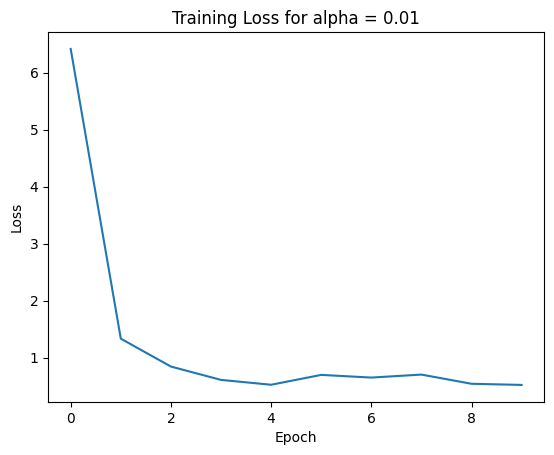

Accuracy: 0.904
Alpha: 0.05


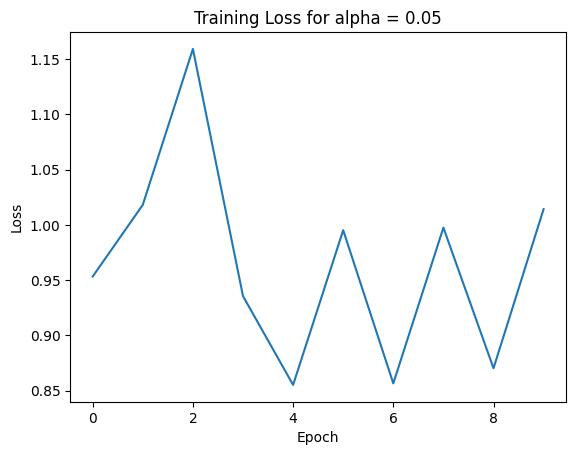

Accuracy: 0.871
Alpha: 0.1


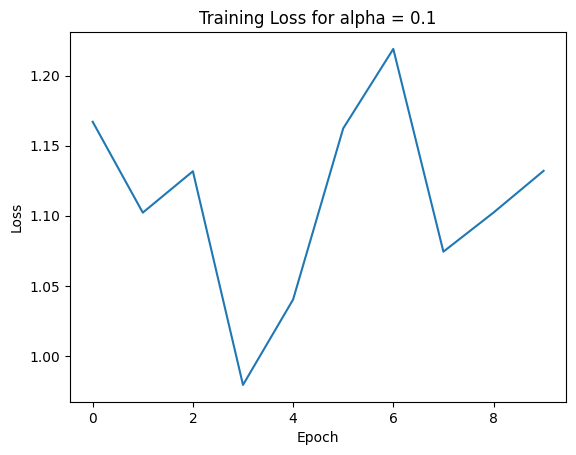

Accuracy: 0.84775
Best alpha: 0.005, Best accuracy: 0.9109166666666667


In [ ]:


train_data = TensorDataset(x_train, y_train)
print(train_data.tensors[0].shape[1])
train_size = int(TRAIN_VAL_SPLIT_RATIO * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])
# make train data dataset again
train_data = TensorDataset(train_data.dataset.tensors[0], train_data.dataset.tensors[1])

val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

best_alpha, best_acc, best_model = solve_bilevel(ALPHA_RANGE, train_data, val_loader, OPTIMIZER, OPTIMIZER_PARAMS, NUM_EPOCHS, BATCH_SIZE)

In [ ]:
# Test the best model
x_test = test_data.data.view(-1, 28*28).float() / 255.0
y_test = test_data.targets
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_acc = test(best_model, test_loader)
print(f'Test accuracy: {test_acc}')

Test accuracy: 0.9089
